# ChromVAR Affinity

Run ChromVAR after stratifying by motif affinity, typically on peaks opened newly in high OSK state. See notebook by same name in `20200607_ChromVAR`.

Inputs:
1. Peak x Counts matrix
2. Peaks
3. scATAC Metadata
4. Motif hits in high OSK peaks with affinity scores
5. Fibroblast peaks
6. D2 only high OSK peaks
7. Configs

In [2]:
library(chromVAR)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Matrix)
library(SummarizedExperiment)
library(motifmatchr)
library(ggplot2)
library(scales)
library(ggseqlogo)
library(BiocParallel)
set.seed(2021)



No methods found in package ‘IRanges’ for request: ‘score’ when loading ‘TFBSTools’

Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.ma

In [3]:
register(MulticoreParam(20, progressbar = TRUE))

## Load Data

In [74]:
cluster_config = read.table("../../figures_factory//configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

# print friendly
cluster_config[9, "description"] = "Partially\nreprogrammed"

cluster_config = cluster_config[!is.na(cluster_config$cluster), ]
rownames(cluster_config) = as.factor(cluster_config$cluster)
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#B03743,Fibroblast,1
2,2,#E85F6D,Fibroblast-like,3
3,3,#7C2730,Fibroblast-like,2
4,4,#F0A118,Intermediate,12
5,5,#78A824,Pre-iPSC,13
6,6,#A6D854,Pre-iPSC,14
7,7,#F01D35,Fibroblast-like,5
8,8,#13C4A3,iPSC,15
9,9,#406614,Partially reprogrammed,10


In [4]:
pmat = readMM("../../analysis/20200206_pmat_snapATAC/sessions/20210717_n62599/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  62599 530910

In [5]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20210717_n62599/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 62599     6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,-1.8037916,-9.507773,1,D0_AAACACGCTAGTACGG
D0_AAACACGCTCTTCAAG,AAACACGCTCTTCAAG,D0,0.7074551,-9.406457,1,D0_AAACACGCTCTTCAAG
D0_AAACACGCTGATCCAT,AAACACGCTGATCCAT,D0,-2.9559933,-7.641148,1,D0_AAACACGCTGATCCAT
D0_AAACCCTGACCGCTAG,AAACCCTGACCGCTAG,D0,-3.6119107,-8.443144,1,D0_AAACCCTGACCGCTAG
D0_AAACCCTGATTGCAGT,AAACCCTGATTGCAGT,D0,0.5002119,-8.759449,3,D0_AAACCCTGATTGCAGT


In [6]:
regions = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20210717_n62599/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 530910      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr17_32960817_32961317,chr17,32960817,32961317,chr17_32960817_32961317
chr17_75764252_75764752,chr17,75764252,75764752,chr17_75764252_75764752
chr17_1473114_1473614,chr17,1473114,1473614,chr17_1473114_1473614
chr17_4206897_4207397,chr17,4206897,4207397,chr17_4206897_4207397
chr17_423409_423909,chr17,423409,423909,chr17_423409_423909
chr17_1964634_1965134,chr17,1964634,1965134,chr17_1964634_1965134


In [7]:
peaks_gr = GRanges(sub("_", "-", sub("_", ":", rownames(regions))))
peaks_gr

GRanges object with 530910 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]    chr17 32960817-32961317      *
       [2]    chr17 75764252-75764752      *
       [3]    chr17   1473114-1473614      *
       [4]    chr17   4206897-4207397      *
       [5]    chr17     423409-423909      *
       ...      ...               ...    ...
  [530906]     chrY   7260941-7261441      *
  [530907]     chrY 13337357-13337857      *
  [530908]     chrY   7109991-7110491      *
  [530909]     chrY 13241191-13241691      *
  [530910]     chrY   7936006-7936506      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [8]:
length(unique(width(peaks_gr)))

[1] 1

In [9]:
unique(width(peaks_gr))

[1] 501

In [10]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [11]:
pmatRowSums = Matrix::rowSums(pmat)

In [12]:
pmatColSums = Matrix::colSums(pmat)

In [13]:
min(pmatRowSums)

[1] 487

In [14]:
min(pmatColSums)

[1] 22

Fibroblast peaks

In [15]:
fibr_peaks = read.table("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx1/peak/overlap_reproducibility/overlap.optimal_peak.narrowPeak.gz")
fibr_peaks = fibr_peaks[,1:3]
colnames(fibr_peaks) = c("chr", "start", "end")
fibr_peaks = GRanges(fibr_peaks)
fibr_peaks

GRanges object with 283475 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1 100009510-100009794      *
       [2]     chr1 100036850-100037066      *
       [3]     chr1 100037588-100039175      *
       [4]     chr1 100037588-100039175      *
       [5]     chr1 100037588-100039175      *
       ...      ...                 ...    ...
  [283471]     chrY     7836422-7836664      *
  [283472]     chrY     7873996-7874589      *
  [283473]     chrY     7935906-7936641      *
  [283474]     chrY     7941921-7942148      *
  [283475]     chrY     9141829-9142025      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [16]:
# peaks called on D2 cells subsetted to high OSK state
d2_high_OSK_peaks = read.table("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/extra/D2_c11/croo/peak/overlap_reproducibility//overlap.optimal_peak.narrowPeak.gz")
d2_high_OSK_peaks = d2_high_OSK_peaks[,1:3]
colnames(d2_high_OSK_peaks) = c("chr", "start", "end")
d2_high_OSK_peaks = GRanges(d2_high_OSK_peaks)
d2_high_OSK_peaks

GRanges object with 235559 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1 100005409-100006153      *
       [2]     chr1 100005409-100006153      *
       [3]     chr1 100020459-100020938      *
       [4]     chr1 100025651-100026395      *
       [5]     chr1 100025651-100026395      *
       ...      ...                 ...    ...
  [235555]     chrY     7588262-7588786      *
  [235556]     chrY     7682350-7682835      *
  [235557]     chrY     7795804-7796157      *
  [235558]     chrY     7857768-7858169      *
  [235559]     chrY     7879479-7880468      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

### Make motifs x peak matrix

Take OCTSOX/KLF/other motif hits in peaks in D2 (high OSK) not in fibroblasts. Split into high and low affinity and perform separately.

In [17]:
klf_hits = read.table("./motif_scans/scans/importance_thresholded/KLF.tsv", header=T)
klf_hits = GRanges(klf_hits)
klf_hits

GRanges object with 126318 ranges and 3 metadata columns:
           seqnames            ranges strand |     score        seq
              <Rle>         <IRanges>  <Rle> | <numeric>   <factor>
       [1]    chr17 67771433-67771442      + |  7.178193 TCCCCGCCCT
       [2]    chr17 62098641-62098650      - |  7.151511 AGGGTGGAAC
       [3]    chr17 62098673-62098682      - | 10.893316 AGGGTGTGGC
       [4]    chr17 33487610-33487619      - |  8.785434 TGGGTGTGTC
       [5]    chr17 33487624-33487633      - |  8.343779 AGGGTGTTGC
       ...      ...               ...    ... .       ...        ...
  [126314]     chrY   7438995-7439004      - |  4.158981 GAGGTGTGTC
  [126315]     chrY 13377212-13377221      - |  3.284662 AGGGCTTGGC
  [126316]     chrY 19081966-19081975      + |  6.906854 ACCACACCTA
  [126317]     chrY 19081979-19081988      + |  3.063737 GGAACTCCCT
  [126318]     chrY 19082211-19082220      + |  7.184154 CCTACACCCT
                         imp
                   <numeric>


In [18]:
octsox_hits = read.table("./motif_scans/scans/importance_thresholded/OCTSOX.tsv", header=T)
octsox_hits = GRanges(octsox_hits)
octsox_hits

GRanges object with 69617 ranges and 3 metadata columns:
          seqnames            ranges strand |     score              seq
             <Rle>         <IRanges>  <Rle> | <numeric>         <factor>
      [1]    chr17 20216024-20216039      - |  5.219048 TGCTGCATAATAACAG
      [2]    chr17 20216067-20216082      - |  9.142086 ATTAACATATGAAGAG
      [3]    chr17 33487642-33487657      - |  5.217108 ATTAACATTTGAGTCA
      [4]    chr17     525382-525397      - | 10.497469 CTTTACATAAAAATGA
      [5]    chr17 20480405-20480420      + |  5.626745 ATATTCTAATGCACTC
      ...      ...               ...    ... .       ...              ...
  [69613]     chrY   7438974-7438989      + |  7.793314 TGTTTGTCTTGCAGAT
  [69614]     chrY 13308844-13308859      + |  6.204922 ATATTGTCATTAAAAG
  [69615]     chrY 13308880-13308895      - |   5.69622 TGCTGCAAATGAATAG
  [69616]     chrY 13377007-13377022      - | 11.011294 ATCTACATCACAAAAA
  [69617]     chrY 13377234-13377249      - |  8.381292 ATTTGCACAAC

In [19]:
octsox_in_fibr_idx = unique(queryHits(findOverlaps(octsox_hits, fibr_peaks)))
length(octsox_in_fibr_idx) 

octsox_non_fibr_hits = octsox_hits[-octsox_in_fibr_idx]

[1] 6938

In [20]:
klf_in_fibr_idx = unique(queryHits(findOverlaps(klf_hits, fibr_peaks)))
length(klf_in_fibr_idx) 

klf_non_fibr_hits = klf_hits[-klf_in_fibr_idx]

[1] 30588

In [21]:
length(octsox_non_fibr_hits)
length(klf_non_fibr_hits)

[1] 62679

[1] 95730

In [22]:
# consider within peaks that are new at D2 (not necessarily all of high OSK, which contains D4 cells too)
peak_set_of_interest = peaks_gr[unique(subjectHits(findOverlaps(d2_high_OSK_peaks, 
                                                                peaks_gr, 
                                                                minoverlap = 200)))]

In [23]:
octsox_in_D2_peaks = unique(queryHits(findOverlaps(octsox_non_fibr_hits, peak_set_of_interest)))
length(octsox_in_D2_peaks) 

octsox_non_fibr_D2_only_hits = octsox_non_fibr_hits[octsox_in_D2_peaks]

[1] 42013

In [24]:
klf_in_D2_peaks = unique(queryHits(findOverlaps(klf_non_fibr_hits, peak_set_of_interest)))
length(klf_in_D2_peaks) 

klf_non_fibr_D2_only_hits = klf_non_fibr_hits[klf_in_D2_peaks]

[1] 69890

In [25]:
quantile(octsox_non_fibr_D2_only_hits$score, c(.25,.5,.95))
quantile(klf_non_fibr_D2_only_hits$score, c(.25,.5,.95))

25%       50%       95% 
 6.020743  7.390570 10.875807

25%      50%      95% 
4.598070 6.235897 9.699493

In [26]:
# motif strengths will be split into these percentile buckets
# SPLITS = c(0,0.2,.4,.6,.8,.9,.95)
SPLITS = c(0, 0.4, .9)

In [143]:
quantile(octsox_non_fibr_D2_only_hits$score, SPLITS)
quantile(klf_non_fibr_D2_only_hits$score, SPLITS)

0%       40%       90% 
 4.230908  6.873802 10.069430

0%      40%      90% 
2.439167 5.631392 8.844794

In [27]:
octsox_motif_x_peak = matrix(0, nrow = length(peaks_gr), ncol=length(SPLITS))

for (i in seq(length(SPLITS))) {
    cur_perc = SPLITS[i]
    cur_hits = octsox_non_fibr_D2_only_hits[octsox_non_fibr_D2_only_hits$score >= quantile(octsox_non_fibr_D2_only_hits$score, cur_perc)]
    octsox_motif_x_peak[unique(queryHits(findOverlaps(peaks_gr, cur_hits))), i] = 1
}

In [28]:
klf_motif_x_peak = matrix(0, nrow = length(peaks_gr), ncol=length(SPLITS))

for (i in seq(length(SPLITS))) {
    cur_perc = SPLITS[i]
    cur_hits = klf_non_fibr_D2_only_hits[klf_non_fibr_D2_only_hits$score >= quantile(klf_non_fibr_D2_only_hits$score, cur_perc)]
    klf_motif_x_peak[unique(queryHits(findOverlaps(peaks_gr, cur_hits))), i] = 1
}

In [29]:
colSums(octsox_motif_x_peak)
colSums(klf_motif_x_peak)

[1] 32361 21572  4080

[1] 46007 31418  6573

In [30]:
table(rowSums(octsox_motif_x_peak))
table(rowSums(klf_motif_x_peak))


     0      1      2      3 
498549  10789  17492   4080 


     0      1      2      3 
484903  14589  24845   6573 

In [31]:
# assign each peak to strongest
for (i in rev(2:length(SPLITS))) {
    octsox_motif_x_peak[octsox_motif_x_peak[,i]>0, 1:i-1] = 0
    klf_motif_x_peak[klf_motif_x_peak[,i]>0, 1:i-1] = 0
}

In [32]:
colSums(octsox_motif_x_peak)
colSums(klf_motif_x_peak)

[1] 10789 17492  4080

[1] 14589 24845  6573

In [33]:
table(rowSums(klf_motif_x_peak))


     0      1 
484903  46007 

In [34]:
# restrict octsox to those without klf and vice-versa
octsox_motif_x_peak[unique(queryHits(findOverlaps(peaks_gr, klf_hits))), ] = 0
klf_motif_x_peak[unique(queryHits(findOverlaps(peaks_gr, octsox_hits))), ] = 0

In [35]:
colSums(octsox_motif_x_peak)
colSums(klf_motif_x_peak)

[1] 3413 7439 1915

[1]  7457 14529  4442

In [147]:
octsox_motif_hits_se <- SummarizedExperiment(
                 assays = list(motifMatches = octsox_motif_x_peak), 
                 colData = DataFrame(name=quantile(octsox_non_fibr_D2_only_hits$score, SPLITS))
    );

klf_motif_hits_se <- SummarizedExperiment(
                 assays = list(motifMatches = klf_motif_x_peak), 
                 colData = DataFrame(name=quantile(klf_non_fibr_D2_only_hits$score, SPLITS))
    );

## ChromVAR

In [37]:
GENOME = BSgenome.Hsapiens.UCSC.hg38

In [38]:
rse <- SummarizedExperiment(
                 assays = list(counts = t(pmat)), 
                 rowRanges = peaks_gr, 
                 colData = DataFrame(Cell_Type=1:nrow(pmat), depth=pmatRowSums)
    );

In [39]:
rse <- addGCBias(rse, genome = GENOME);

Use pre-computed matrix, e.g. from hits loaded above

In [148]:
octsox_motif_mm <- octsox_motif_hits_se
klf_motif_mm <- klf_motif_hits_se

---

In [149]:
octsox_motif_mm_mat = assay(octsox_motif_mm)
colnames(octsox_motif_mm_mat) = octsox_motif_mm$name

In [150]:
klf_motif_mm_mat = assay(klf_motif_mm)
colnames(klf_motif_mm_mat) = klf_motif_mm$name

In [151]:
octsox_dev <- computeDeviations(object = rse, annotations = octsox_motif_mm)
klf_dev <- computeDeviations(object = rse, annotations = klf_motif_mm)

Warning message in matches_check(annotations):
“Annotation object matches converted to logical”


  |======================================================================| 100%



Warning message in matches_check(annotations):
“Annotation object matches converted to logical”


  |======================================================================| 100%



In [152]:
octsox_dev_mat = t(assay(octsox_dev))
klf_dev_mat = t(assay(klf_dev))

In [153]:
colnames(octsox_dev_mat) = octsox_motif_mm$name
colnames(klf_dev_mat) = klf_motif_mm$name

rownames(octsox_dev_mat) = rownames(metaData)
rownames(klf_dev_mat) = rownames(metaData)

head(klf_dev_mat)

,2.439167,5.631392,8.844794
D0_AAACACGCTAGTACGG,-0.5120180,-0.5493178,-0.5659450
D0_AAACACGCTCTTCAAG,-0.3579336,-0.4859066,-0.5906446
D0_AAACACGCTGATCCAT,-0.5054876,-0.5967179,-0.7234659
D0_AAACCCTGACCGCTAG,-0.4100712,-0.4662409,-0.6285953
D0_AAACCCTGATTGCAGT,-0.2905268,-0.3977582,-0.5574704
D0_AAACCGTACACACCTA,-0.5338044,-0.5253084,-0.6915109


In [154]:
# save output
# write.table(dev_mat, file="./out/20201020_n62402/20201119_bpnet.no_iPSC.FDR_0.1_hits.tsv", quote=F, row.names=T, sep='\t')

In [155]:
# variability <- computeVariability(dev)

In [156]:
# head(variability)

In [49]:
# plotVariability(variability, use_plotly = FALSE, n = 20) 

In [50]:
# variability[rev(order(variability$variability)), "name"]

In [157]:
cur_pattern = "8.844794"

In [158]:
options(repr.plot.width = 10, repr.plot.height = 10)

cur_dev = octsox_dev_mat[,cur_pattern]

df = data.frame(metaData, n=cur_dev)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=1, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(cur_dev, 0.0),
                              quantile(cur_dev, 0.98)), 
                      oob = squish, name='ChromVAR Deviation') +
ggtitle(sprintf("ChromVAR Deviations for %s", cur_pattern)) + 
theme_classic(base_size = 16) +
theme(plot.title = element_text(hjust = 0.5),
     axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
     panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

# ggsave("tmp.png", height=10, width=10)

ERROR: Error in octsox_dev_mat[, cur_pattern]: subscript out of bounds


In [53]:
sum(octsox_motif_mm_mat[, cur_pattern])

[1] 1915

In [54]:
frip = 100*Matrix::rowSums(pmat[, which(octsox_motif_mm_mat[, cur_pattern]>0)])/pmatRowSums

In [55]:
cor(frip, octsox_dev_mat[,cur_pattern], method='spearman')

[1] 0.9441467

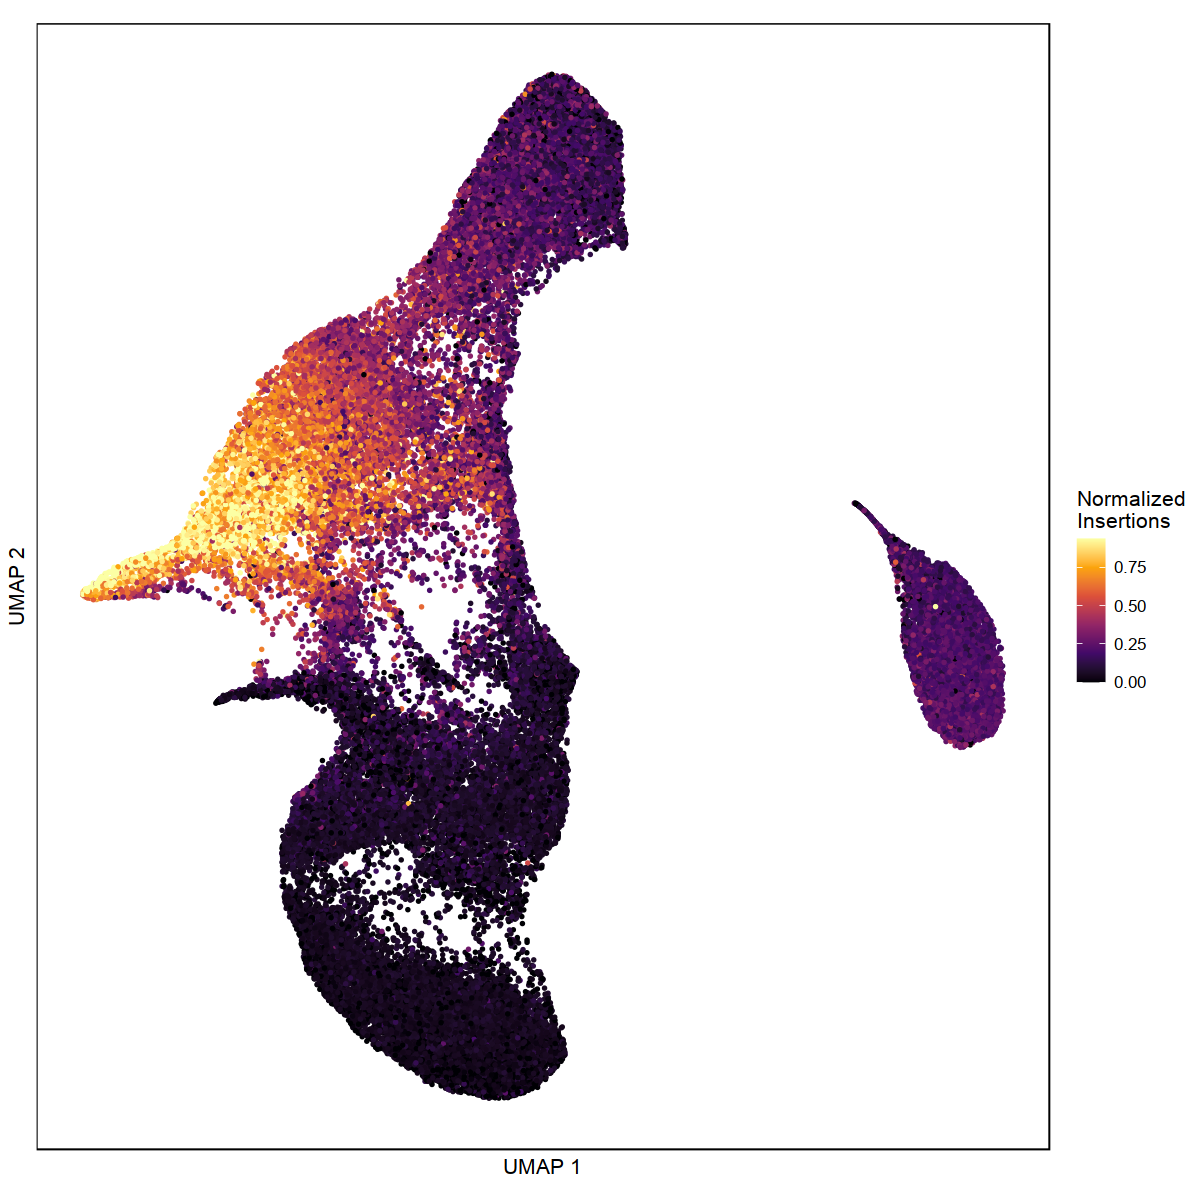

In [56]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(metaData, n=frip)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

frip_plot <- ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(frip, 0.00),
                              quantile(frip, 0.98)), 
                      oob = squish, option="B",
                     name="Normalized\nInsertions") +
theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
# ggtitle(sprintf("FRiP for %s", cur_pattern)) + 
theme(plot.title = element_text(hjust = 0.5)) +
coord_fixed()

frip_plot

In [57]:
library(reshape2)

In [159]:
colSums(is.na(octsox_dev_mat))
colSums(is.na(klf_dev_mat))

4.230908  6.8738022 10.0694302 
         0          0          0

2.439167 5.631392 8.844794 
       0        0        0

In [160]:
# if there's an NA
# for (x in SPLITS) {
#   octsox_dev_mat[(is.na(octsox_dev_mat[,as.character(x)])), as.character(x)] = mean(octsox_dev_mat[,as.character(x)], na.rm=T)  
#   klf_dev_mat[(is.na(klf_dev_mat[,as.character(x)])), as.character(x)] = mean(klf_dev_mat[,as.character(x)], na.rm=T)  
# }

In [ ]:
# colSums(is.na(dev_mat))

In [192]:
ORDER = c(1,8,6,5,4,14,11)

make_plot_df <- function(dev_mat) {
    
    # aggregate chromvar deviations per cluster and min-max normalize per affinity bin
    cluster_mean = aggregate(dev_mat, list(metaData$cluster), mean)
    rownames(cluster_mean) = cluster_mean[,"Group.1"]
    cluster_mean = cluster_mean[,2:ncol(cluster_mean)]
    # cluster_mean[,"Group.1"] = NULL
    cluster_mean_norm = t(t(cluster_mean) - colMins(as.matrix(cluster_mean)))
    cluster_mean_norm = t(t(cluster_mean_norm)/colMaxs(as.matrix(cluster_mean_norm))) # norm to 0-1

    colnames(cluster_mean_norm) = paste(round(as.numeric(colnames(cluster_mean_norm)), 1),
                                        c(round(as.numeric(colnames(cluster_mean_norm)[2:ncol(cluster_mean_norm)]), 1), ""),
                                        sep='-')                              

    ordered_vals = as.data.frame(cluster_mean_norm[ORDER,])
    
    to_plot = melt(as.matrix(ordered_vals))
    to_plot$state = factor(paste(cluster_config[to_plot$Var1, "new_cluster"], cluster_config[to_plot$Var1, "description"], sep=' - '),
                          levels = paste(cluster_config$new_cluster, cluster_config$description, sep=' - ')[ORDER])
    
    to_plot$Var2 = factor(to_plot$Var2, levels = colnames(ordered_vals))
    
    to_plot
}

In [193]:
octsox_df = make_plot_df(octsox_dev_mat)
klf_df = make_plot_df(klf_dev_mat)

In [194]:
make_plot <- function(df, name) {
    p <- ggplot(df, aes(x=state, y=value, group=Var2, color=Var2)) +
    geom_line(size=1.5) + 
    geom_point(size=5) +
    ylab("ChromVAR Dev Normalized") +
    # xlab("OSK Levels ->") +
    theme_bw(base_size=24) +
    ggtitle("Pseudo-binding saturation curves") +
    # scale_color_brewer() +
    scale_color_manual(values=colorRampPalette(c("orange","navyblue"), space = "Lab")(length(SPLITS))) +
    labs(colour=sprintf("%s logodds", name)) +
    theme(axis.text.x=element_text(angle=45, vjust=1, hjust=1),
          axis.title.x = element_blank(),
         plot.title = element_text(hjust=0.5),
    #       panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
         legend.position = "bottom")

    p    
}

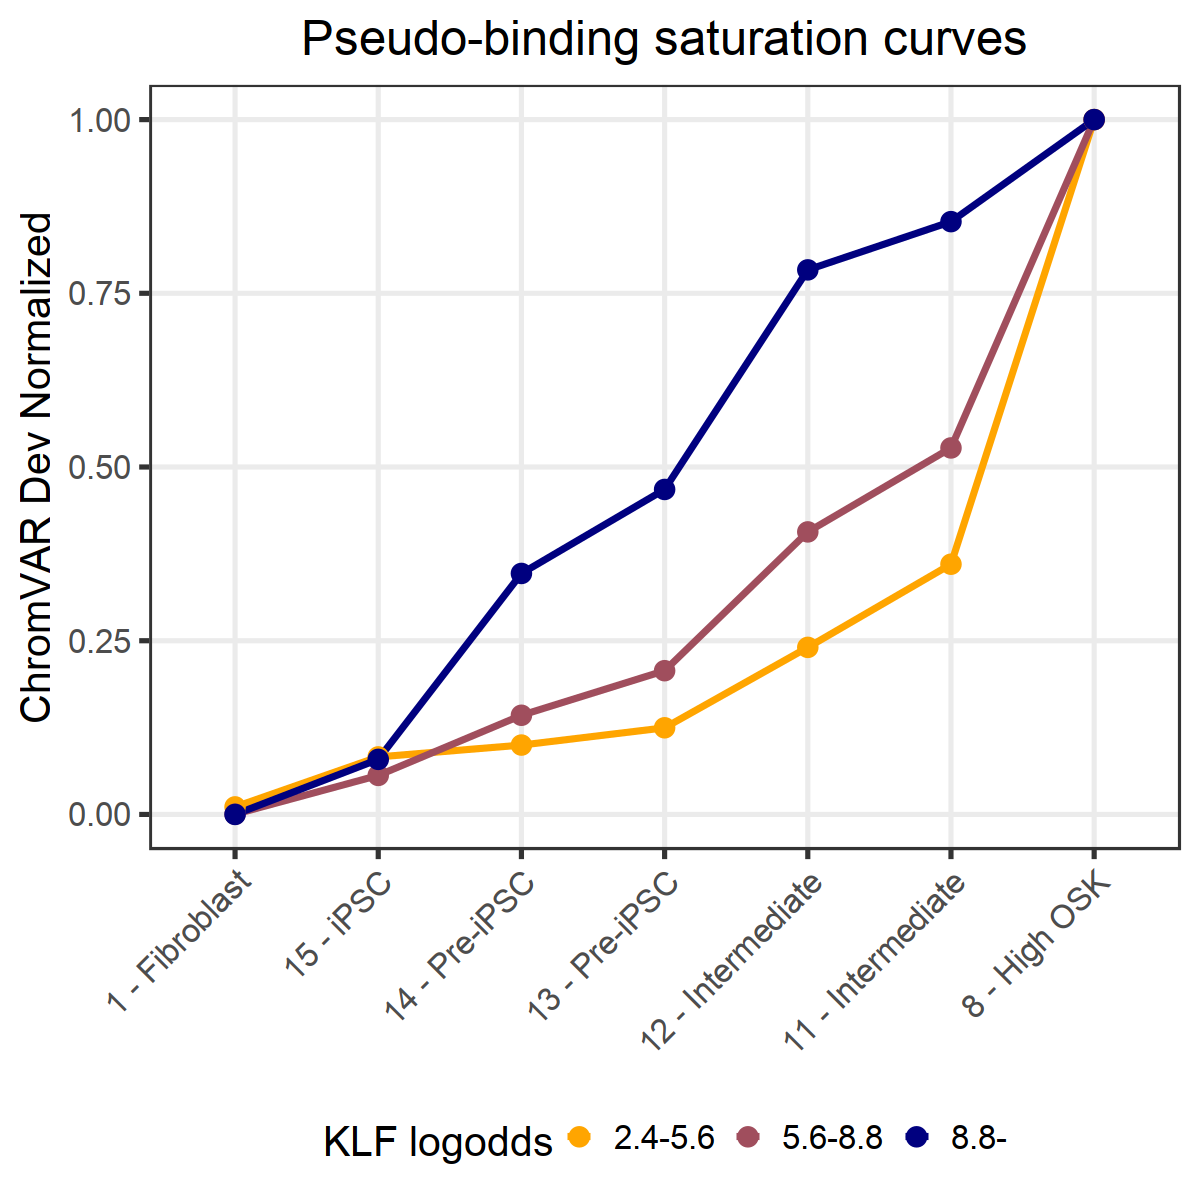

In [198]:
options(repr.plot.width = 10, repr.plot.height = 10)

klf_plot = make_plot(klf_df, "KLF")
klf_plot

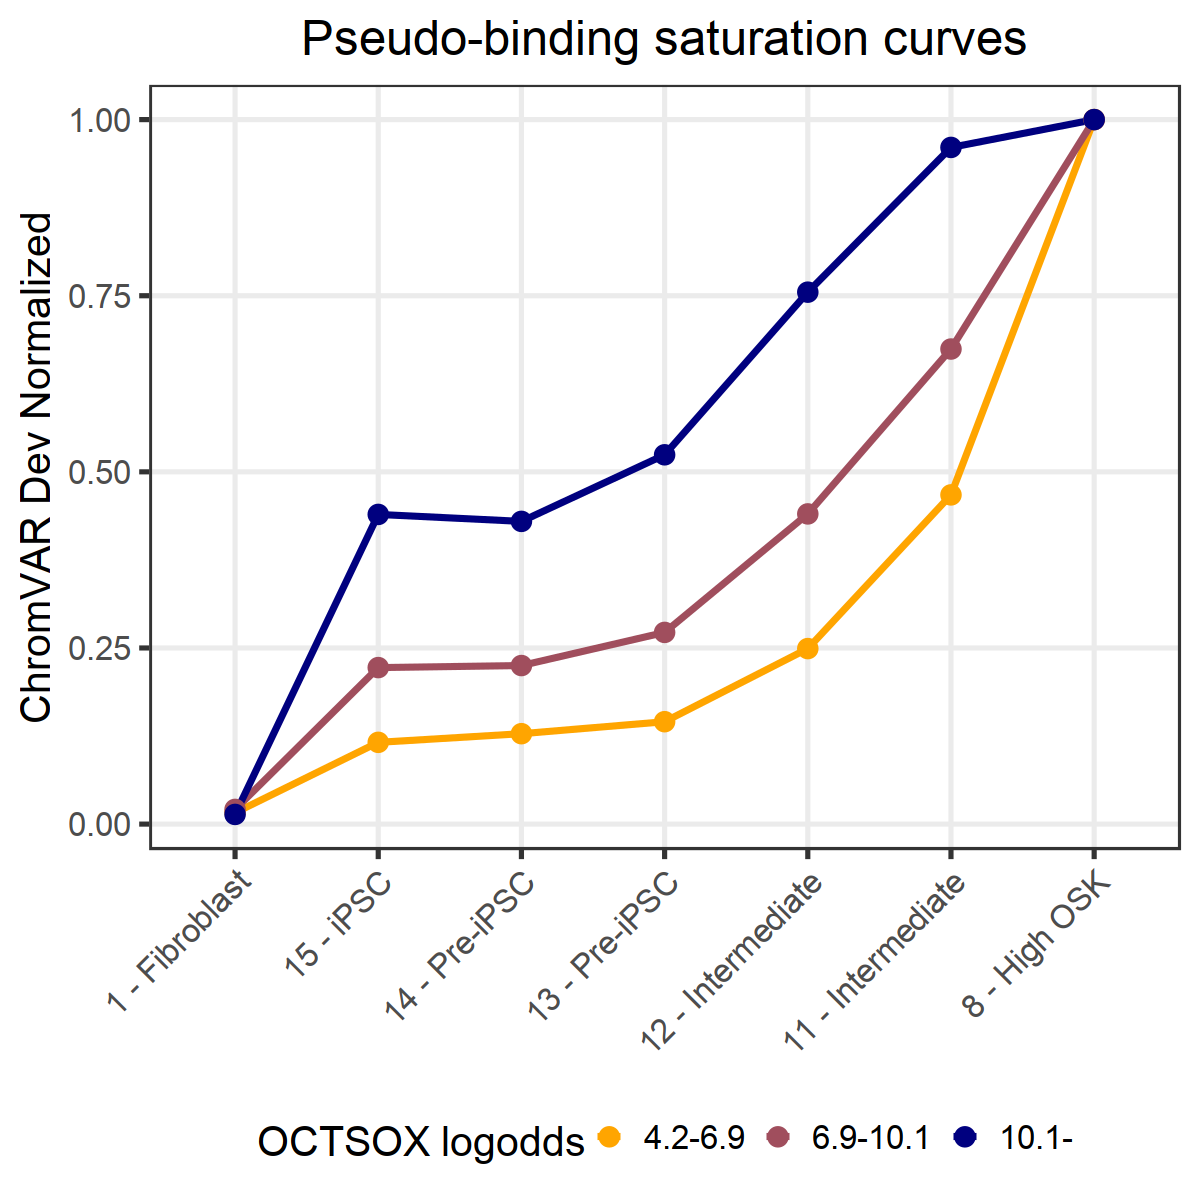

In [200]:
options(repr.plot.width = 10, repr.plot.height = 10)

octsox_plot = make_plot(octsox_df, "OCTSOX")
octsox_plot

In [201]:
ggsave(klf_plot, file="./subfigs/2021224_KLF_saturation.pdf",
       height=10, width=10, useDingbats=F)

ggsave(octsox_plot, file="./subfigs/2021224_OCTSOX_saturation.pdf",
       height=10, width=10, useDingbats=F)

---

In [73]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] reshape2_1.4.4                    ggseqlogo_0.1                    
 [3] scales_1.1.0                      ggplot2_3.3.3                    
 [5] motifmatchr_1.8.0                 SummarizedExperiment_1.16.1      
 [7] DelayedArray_0.12.3               BiocParallel_1.20

### Permuted Controls

In [ ]:
# 1 shuffle (for control)
# motif_x_peak[rowSums(motif_x_peak)==1,] = motif_x_peak[(rowSums(motif_x_peak)==1),][sample(sum(rowSums(motif_x_peak)==1)), ]

In [51]:
# multiple permuted controls (have to run in sets of 100)
control_spreads = c()

for (i in range(10)) {
    permuted_controls = list()
    for (i in seq(100)) {
        permuted_controls[[i]] = motif_x_peak
        permuted_controls[[i]][rowSums(motif_x_peak)==1,] = motif_x_peak[(rowSums(motif_x_peak)==1),][sample(sum(rowSums(motif_x_peak)==1)), ]
        colnames(permuted_controls[[i]]) = paste(i, SPLITS, sep='_')
     }

    permuted_controls = do.call(cbind, permuted_controls)
    
    motif_hits_se <- SummarizedExperiment(
                 assays = list(motifMatches = permuted_controls), 
                 colData = DataFrame(name=colnames(permuted_controls))
    );
    
    motif_mm <- motif_hits_se
    motif_mm_mat = assay(motif_mm)
    colnames(motif_mm_mat) = motif_mm$name
        
    dev <- computeDeviations(object = rse, annotations = motif_mm)
    dev_mat = t(assay(dev))
    
    colnames(dev_mat) = motif_mm$name
    rownames(dev_mat) = rownames(metaData)
    
    # aggregate over clusters
    cluster_mean = aggregate(dev_mat, list(metaData$cluster), mean)
    rownames(cluster_mean) = cluster_mean[,"Group.1"]
    cluster_mean = cluster_mean[,2:ncol(cluster_mean)]
    # cluster_mean[,"Group.1"] = NULL
    cluster_mean_norm = t(t(cluster_mean) - colMins(as.matrix(cluster_mean)))
    cluster_mean_norm = t(t(cluster_mean_norm)/colMaxs(as.matrix(cluster_mean_norm))) # norm to 0-1

    colnames(cluster_mean_norm) = paste(colnames(cluster_mean_norm), c(colnames(cluster_mean_norm)[2:ncol(cluster_mean_norm)],1), sep='-')
    
    ORDER = c(4,8,2,7,1,5)
    ordered_vals = as.data.frame(cluster_mean_norm[ORDER,])

    # change rownames to order of samples
    rownames(ordered_vals) = rev(seq(nrow(ordered_vals)))

    # compute spreads
    for (i in seq(100)) {
        cur = as.matrix(ordered_vals[,((i-1)*length(SPLITS)+1):(i*length(SPLITS))])
        control_spreads = c(control_spreads, sum(rowMaxs(cur)-rowMins(cur)))
    }
}

Warning message in matches_check(annotations):
“Annotation object matches converted to logical”


  |======================================================================| 100%



Warning message in matches_check(annotations):
“Annotation object matches converted to logical”


  |======================================================================| 100%



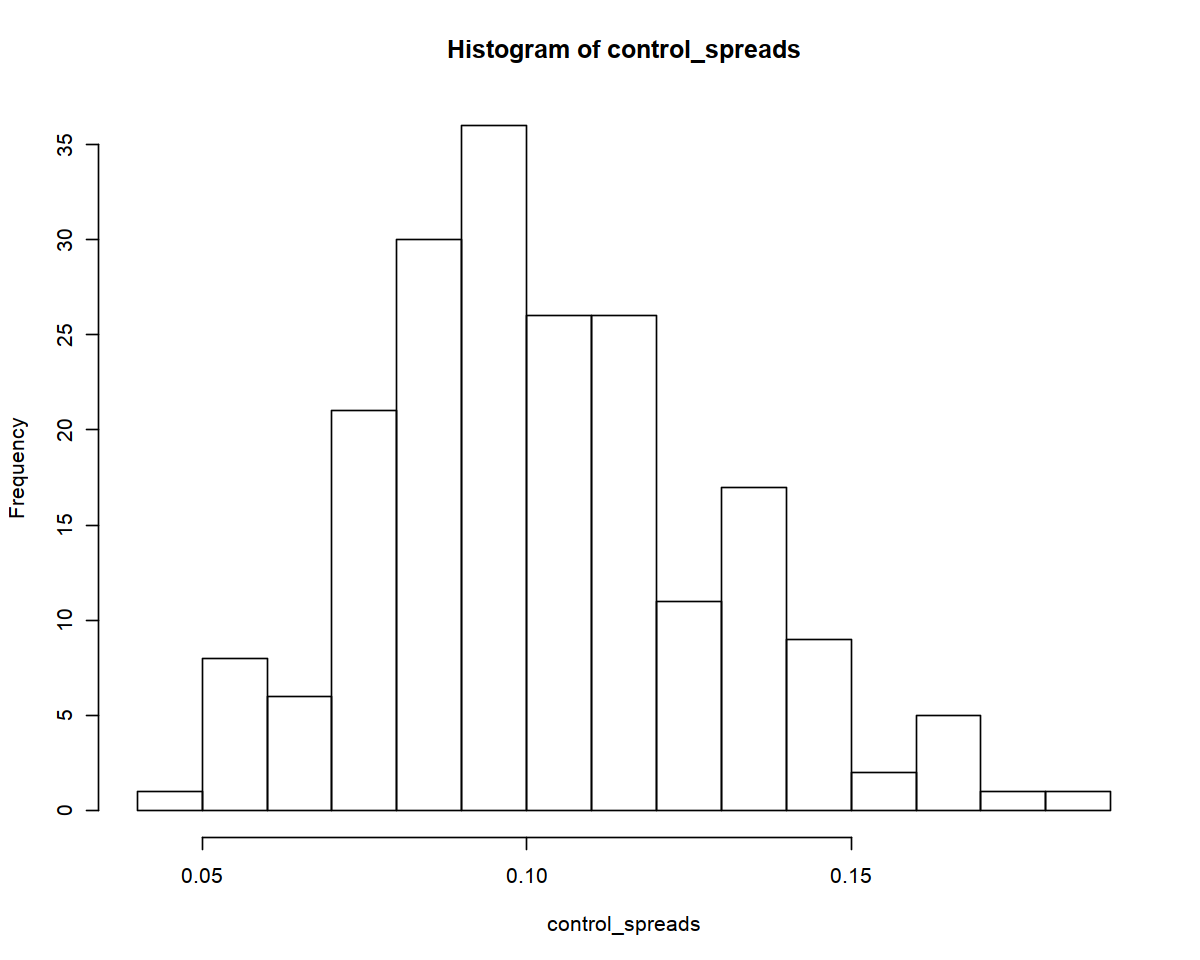

In [55]:
hist(control_spreads, breaks=13)

In [57]:
to_plot = melt(as.matrix(ordered_vals))

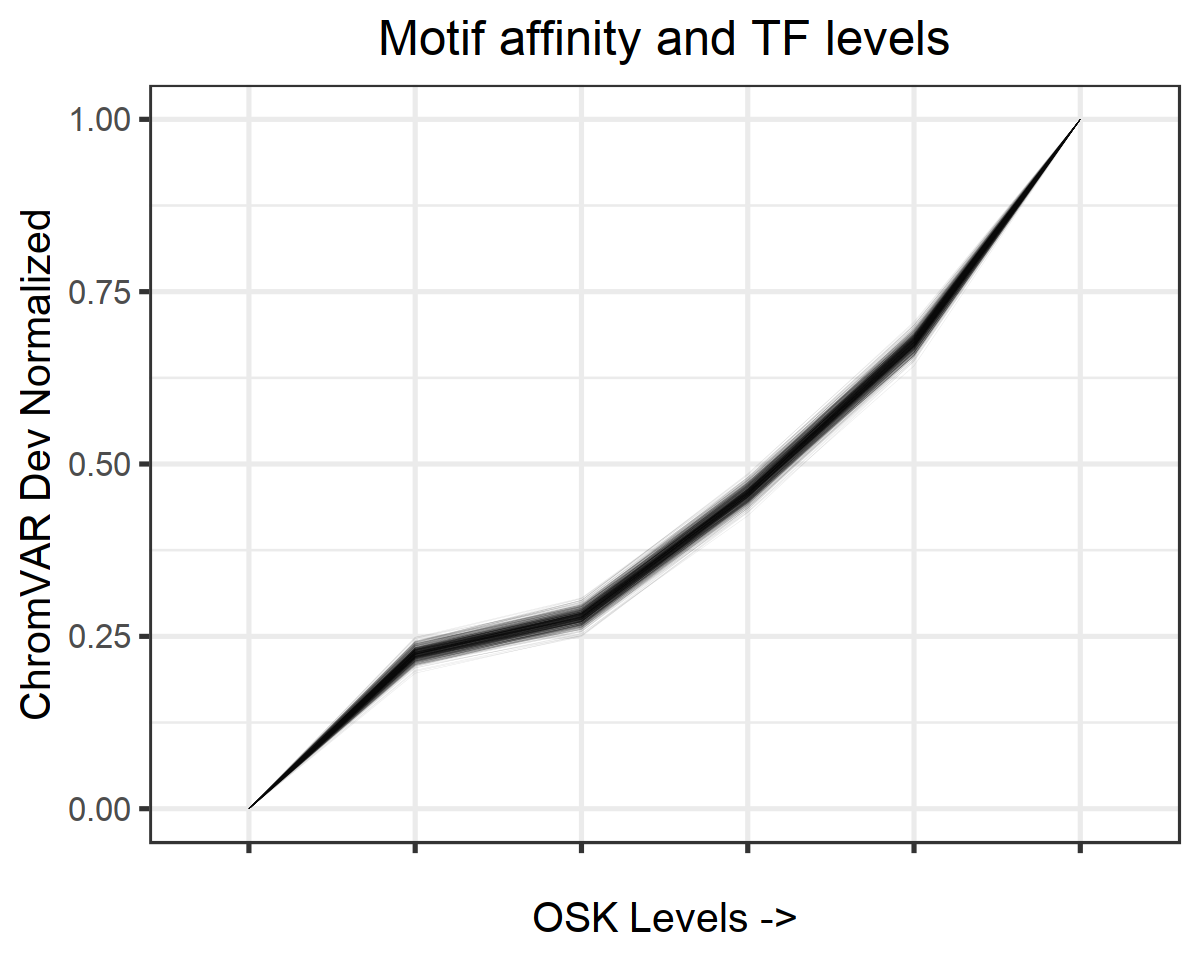

In [82]:
options(repr.plot.width = 10, repr.plot.height = 8)

p <- ggplot(to_plot, aes(x=factor(Var1), y=value, group=Var2)) +
geom_line(size=.1, color='black', alpha=.1) + 
# geom_point(size=5) +
ylab("ChromVAR Dev Normalized") +
xlab("OSK Levels ->") +
theme_bw(base_size=24) +
ggtitle("Motif affinity and TF levels") +
# scale_color_brewer() +
# scale_color_manual(values=colorRampPalette(c("orange","navyblue"), space = "Lab")(length(SPLITS)*100)) +
labs(colour="OCTSOX affinity") +
theme(axis.text.x=element_text(color="white"),
     plot.title = element_text(hjust=0.5),
     legend.position = "bottom")

p

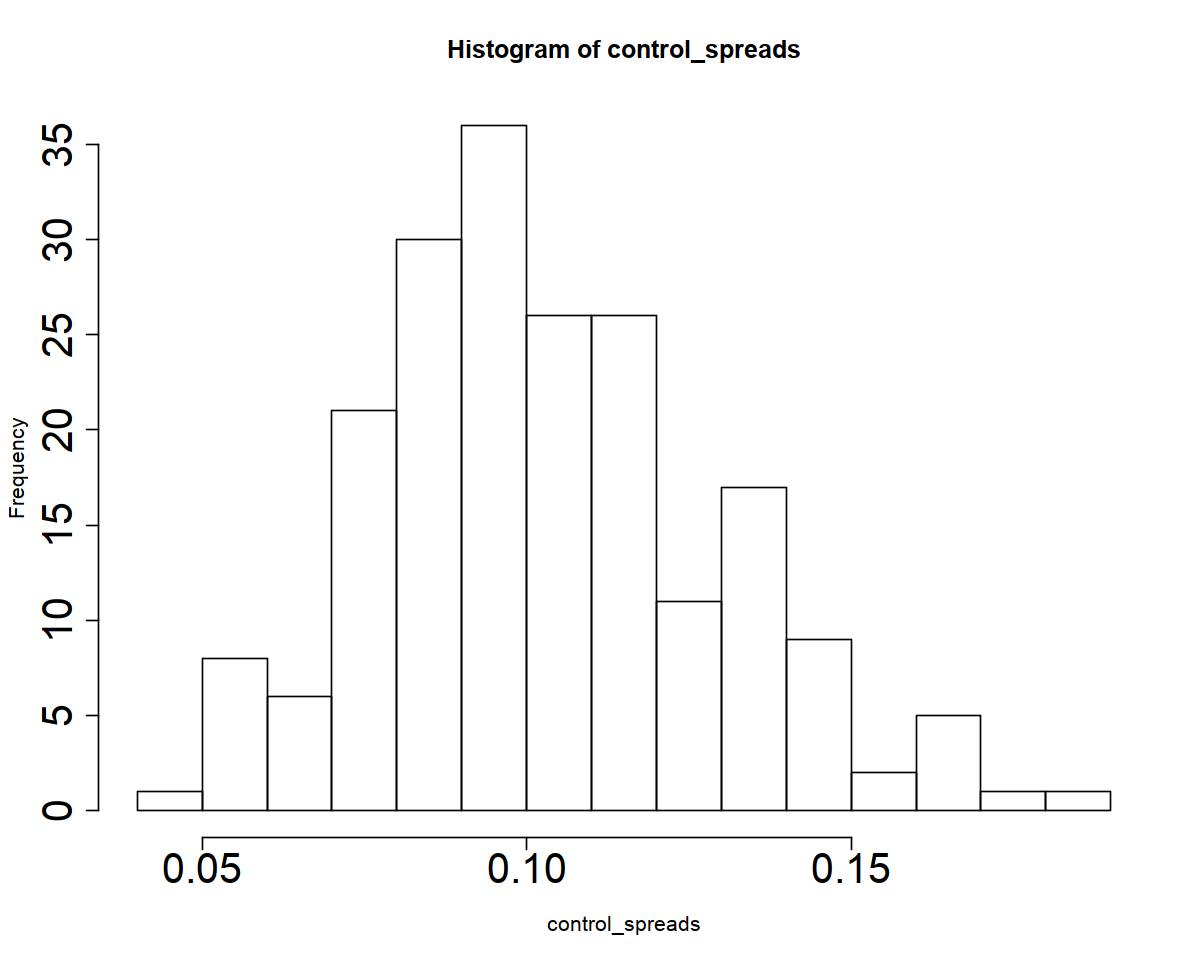

In [78]:
hist(control_spreads, breaks=10, cex.axis=2)

### SessionInfo

In [519]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] reshape2_1.4.4                    ggseqlogo_0.1                    
 [3] scales_1.1.0                      ggplot2_3.3.3                    
 [5] motifmatchr_1.8.0                 SummarizedExperiment_1.16.1      
 [7] DelayedArray_0.12.3               BiocParallel_1.20